# TIME SERIES MODELING WITH ARIMA IN PYTHON

## preparing and cleaning the data

### import packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import cumsum
import os
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import matplotlib.gridspec as gridspec


import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
import joblib

#demonstrate which version of python is being used 
from platform import python_version
print("The Python version used for this analysis is: ", python_version())

The Python version used for this analysis is:  3.8.5


In [2]:
os.getcwd()

'/Users/katherinevoakes/Desktop/SCHOOL/wgu/Third Term/D213'

### Read in the dataset, inspect characteristics, and transform to datetime

In [3]:
df = pd.read_csv('/Users/katherinevoakes/Desktop/teleco_time_series.csv', index_col='Day',
                 parse_dates=True)
df.head(10)

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554
6,0.107654
7,0.493901
8,0.376698
9,0.304075


In [4]:
df.shape

(731, 1)

In [5]:
df.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [7]:
df.isna().any()

Revenue    False
dtype: bool

In [8]:
df.duplicated().any()

False

In [9]:
df['Date'] = (pd.date_range(start=datetime(2019,1,1),
                    periods=df.shape[0], freq='24H'))
df.set_index('Date', inplace=True)
df.head(5)

,Revenue
Date,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554


In [10]:
df.tail(5)

,Revenue
Date,
2020-12-27,16.931559
2020-12-28,17.490666
2020-12-29,16.803638
2020-12-30,16.194814
2020-12-31,16.620798


### Line graph of time series

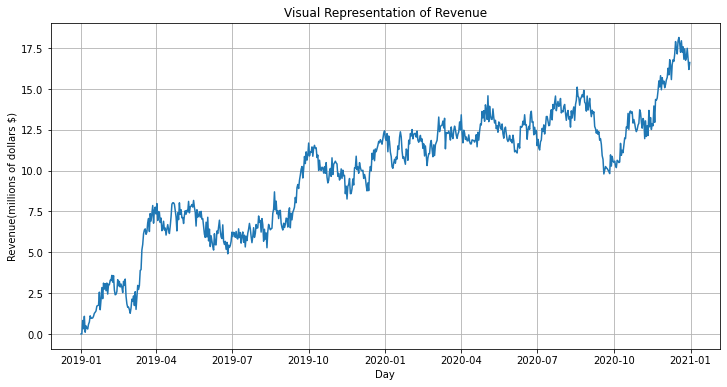

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df.Revenue)
plt.title('Visual Representation of Revenue')
plt.xlabel('Day')
plt.ylabel('Revenue(millions of dollars $)')
plt.grid(True)
plt.show();

### Evaluate for and establish stationarity

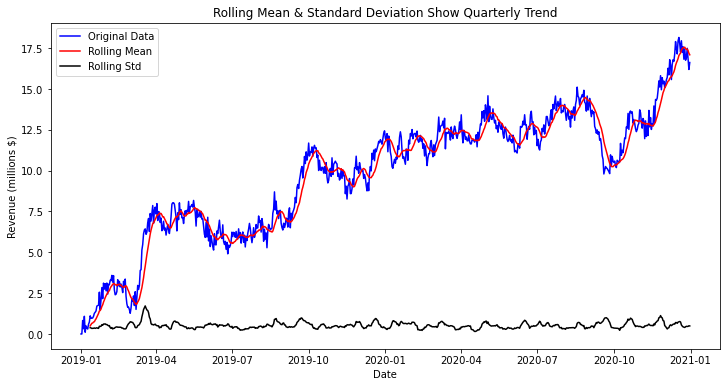

In [12]:
rol_mean = df.rolling(window=12).mean() 
rol_std = df.rolling(window=12).std()


plt.figure(figsize=(12,6))
orig_data = plt.plot(df, color='blue', label='Original Data')
mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
std = plt.plot(rol_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation Show Quarterly Trend')
plt.xlabel('Date')
plt.ylabel('Revenue (millions $)')
plt.show(block=False)

In [13]:
result = adfuller(df['Revenue'], autolag='AIC')
df_output = pd.Series(result[0:4], index=['Test Statistic','p-value','Lags Used','No. Observations'])

for key,value in result[4].items():
    df_output['Critical Value(%s)' %key]=value

print(df_output)

Test Statistic          -1.924612
p-value                  0.320573
Lags Used                1.000000
No. Observations       729.000000
Critical Value(1%)      -3.439352
Critical Value(5%)      -2.865513
Critical Value(10%)     -2.568886
dtype: float64


In [14]:
if result[1]<= 0.05:
    print('The time series is stationary')
else:
    print('The time series is non-stationary')

The time series is non-stationary


In [15]:
df_diff = df.diff().dropna()

print(df_diff.head(5))
print(df_diff.tail(5))

             Revenue
Date                
2019-01-02  0.000793
2019-01-03  0.824749
2019-01-04 -0.505210
2019-01-05  0.762222
2019-01-06 -0.974900
             Revenue
Date                
2020-12-27  0.170280
2020-12-28  0.559108
2020-12-29 -0.687028
2020-12-30 -0.608824
2020-12-31  0.425985


In [16]:
result2 = adfuller(df_diff['Revenue'], autolag='AIC')

df_output2 = pd.Series(result2[0:4], index=['Test Statistic','p-value','Lags Used',
                                          'No. Observations'])

for key,value in result2[4].items():
    df_output2['Critical Value(%s)' %key]=value

print(df_output2)

Test Statistic         -44.874527
p-value                  0.000000
Lags Used                0.000000
No. Observations       729.000000
Critical Value(1%)      -3.439352
Critical Value(5%)      -2.865513
Critical Value(10%)     -2.568886
dtype: float64


In [17]:
if result2[1]<= 0.05:
    print('The time series is stationary')
else:
    print('The time series is non-stationary')

The time series is stationary


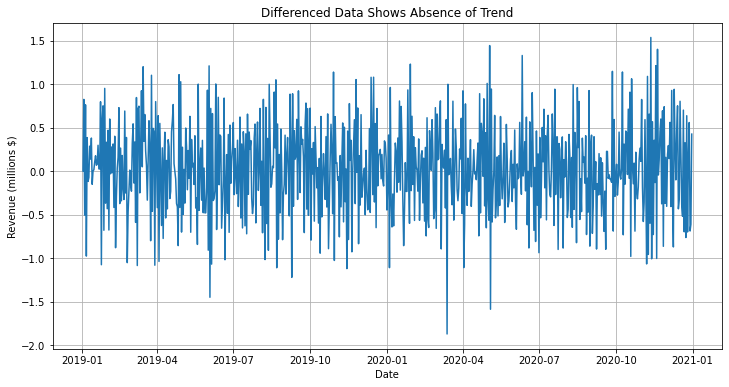

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df_diff.Revenue)
plt.title('Differenced Data Shows Absence of Trend')
plt.xlabel('Date')
plt.ylabel('Revenue (millions $)')
plt.grid(True)

plt.show();

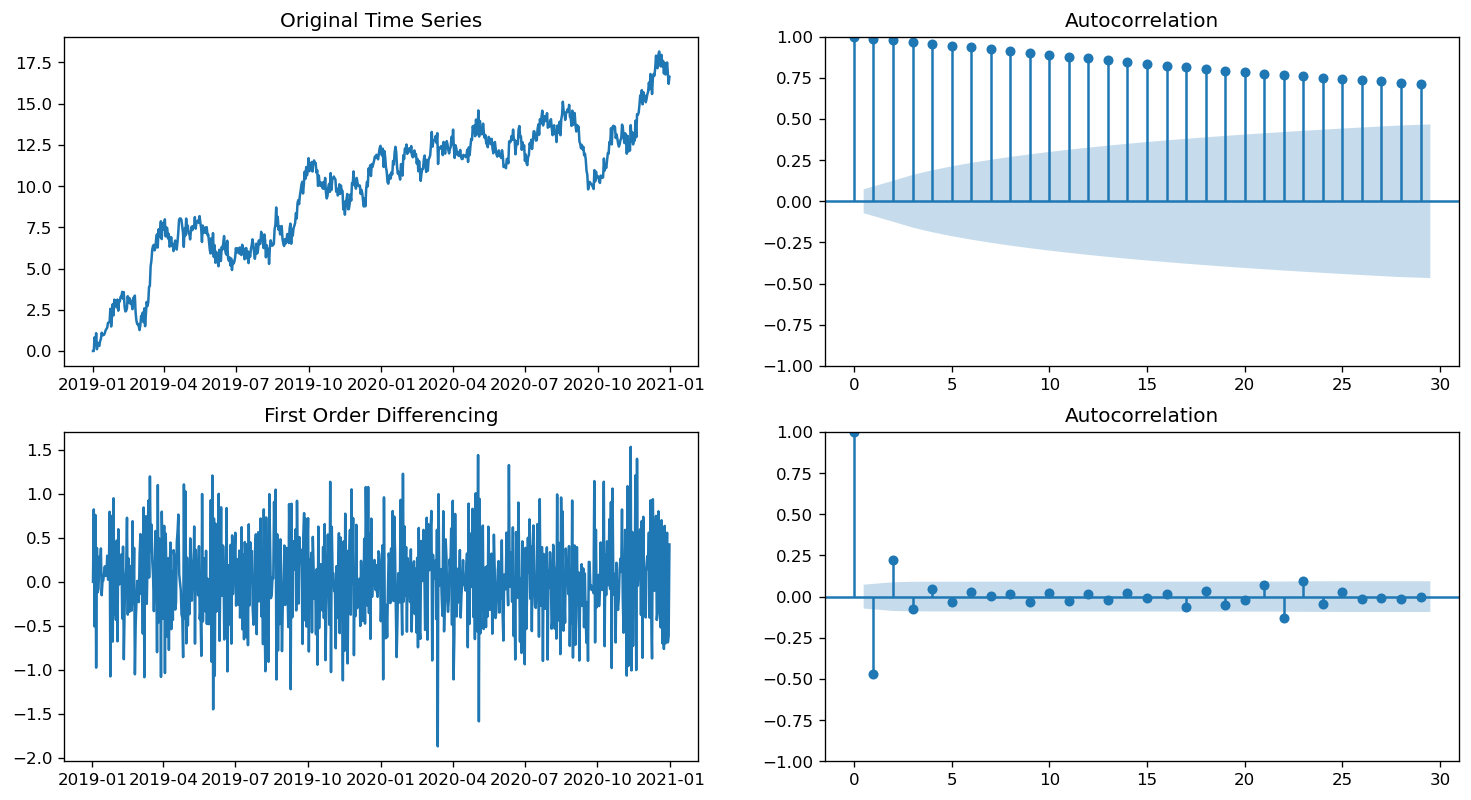

In [19]:
plt.rcParams.update({'figure.figsize':(15,8),'figure.dpi':120})
fig, axes = plt.subplots(2,2)
axes[0,0].plot(df);
axes[0,0].set_title('Original Time Series')
plot_acf(df, ax=axes[0,1]);

#After first differencing
axes[1,0].plot(df_diff);
axes[1,0].set_title('First Order Differencing')

plot_acf(df_diff, ax=axes[1,1]);

plt.show();

### Train and Test splitting

In [20]:
print('df_diff shape :',df_diff.shape)
print(df_diff.info())

train = df_diff.iloc[:-90]
test = df_diff.iloc[-90:]
print('train shape: ', train.shape)
print('test shape: ', test.shape)



df_diff shape : (730, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2019-01-02 to 2020-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB
None
train shape:  (640, 1)
test shape:  (90, 1)


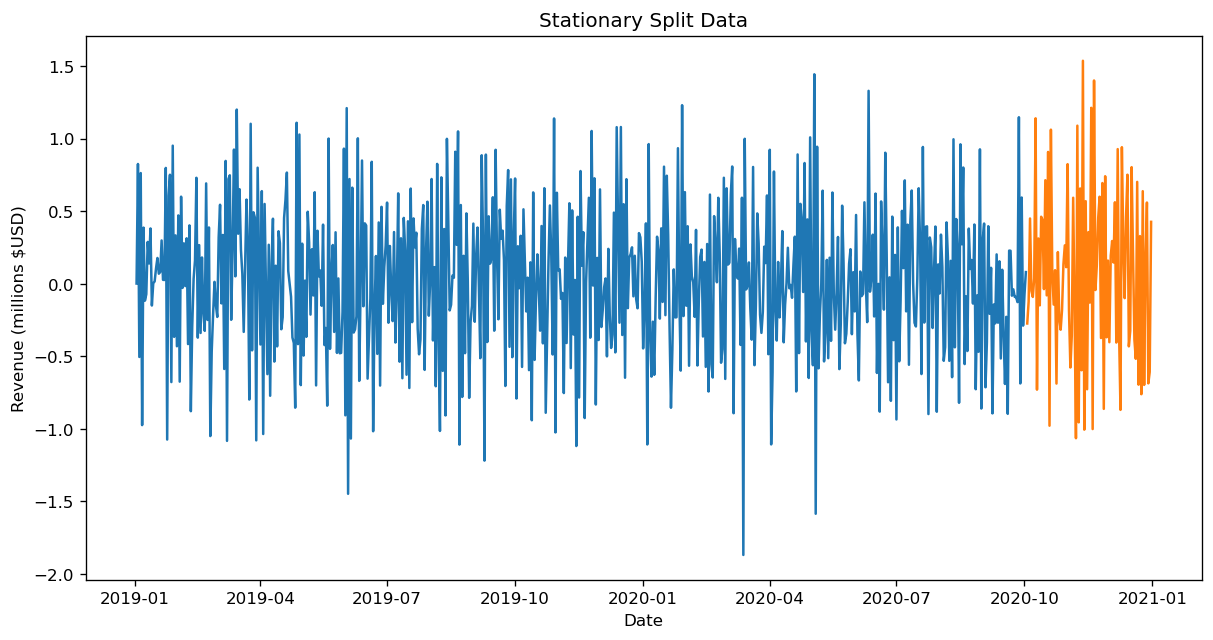

In [21]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.title('Stationary Split Data')
plt.xlabel('Date')
plt.ylabel('Revenue (millions $USD)');

### Save the cleaned, training, and testing datasets for submission

In [22]:
train_df = train
train_df.to_csv('/Users/katherinevoakes/Desktop/d213_train_data.csv')

In [23]:
test_df = test
test_df.to_csv('/Users/katherinevoakes/Desktop/D213_test_data.csv')

In [24]:
df_diff = df_diff
df_diff.to_csv('/Users/katherinevoakes/Desktop/D213_cleaned_ts_data.csv')

### Inspect for seasonal component

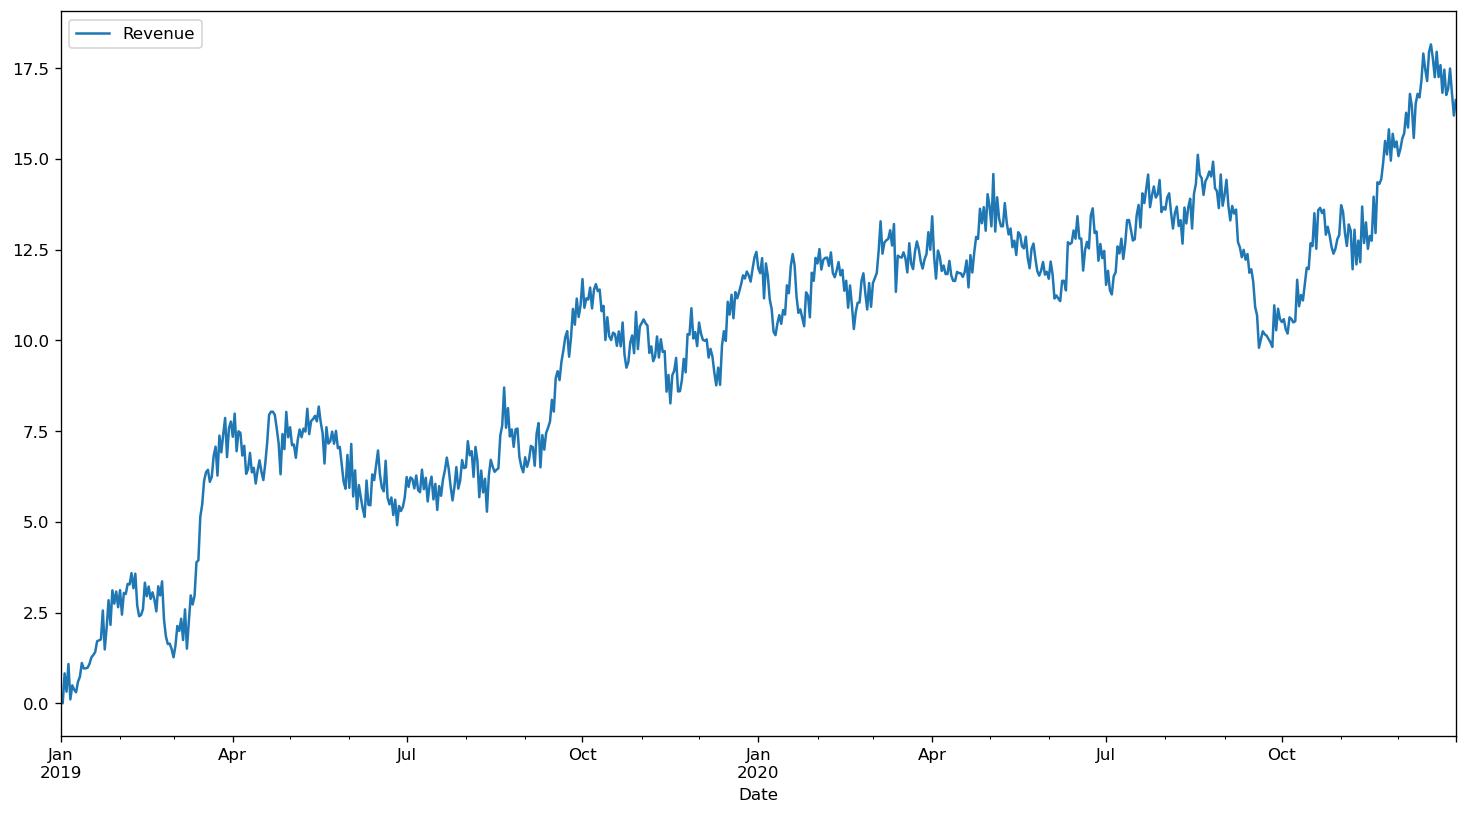

In [25]:
df.plot();

### Inspect for trend 

In [26]:
roll_mean = df['Revenue'].rolling(window=30,center=True).mean()

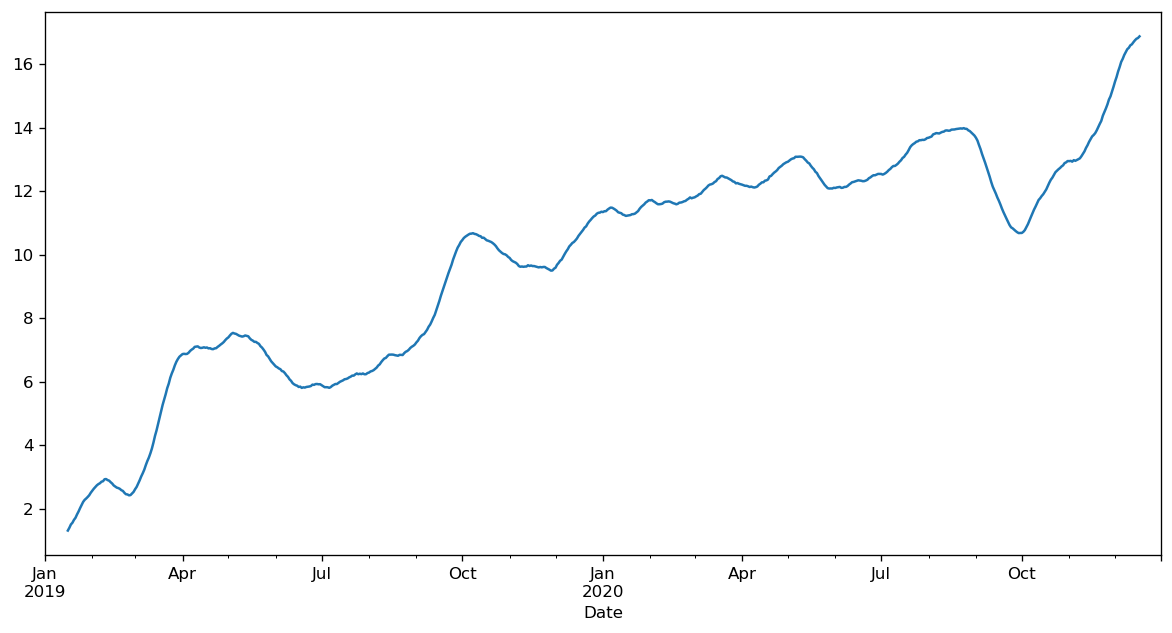

In [27]:
plt.figure(figsize=(12,6))
roll_mean.plot();

### Autocorrelation

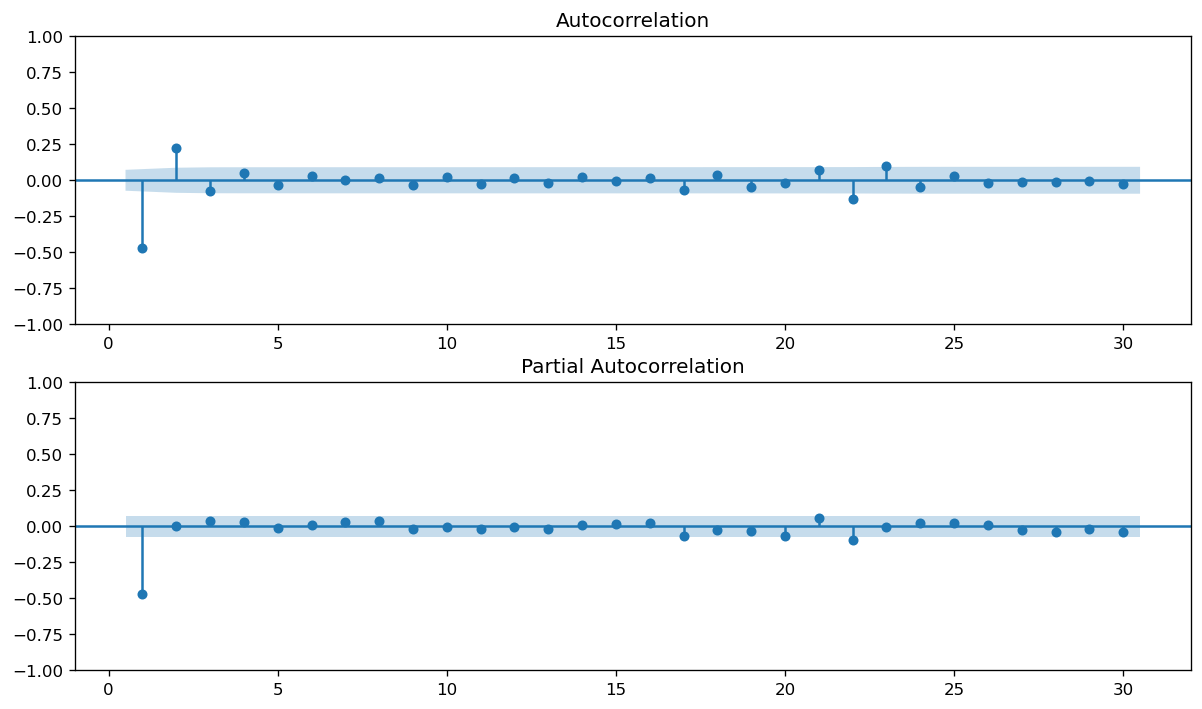

In [28]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7))

plot_acf(df_diff, lags=30, zero=False, ax=ax1)
plot_pacf(df_diff, lags=30, zero=False, ax=ax2)
plt.show();

### Use spectral density plot to verify lack of seasonality

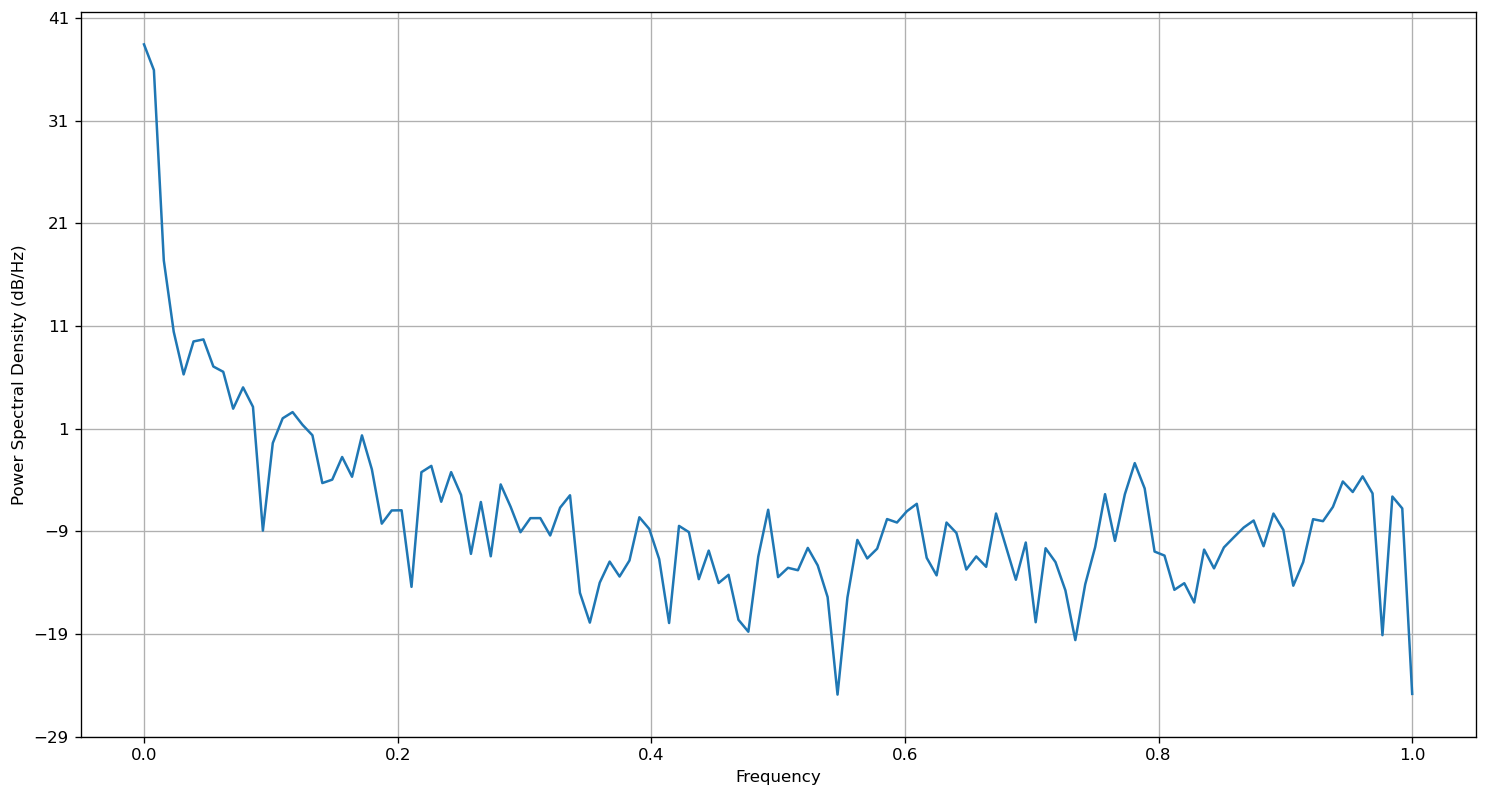

In [29]:
plt.psd(df['Revenue']); 

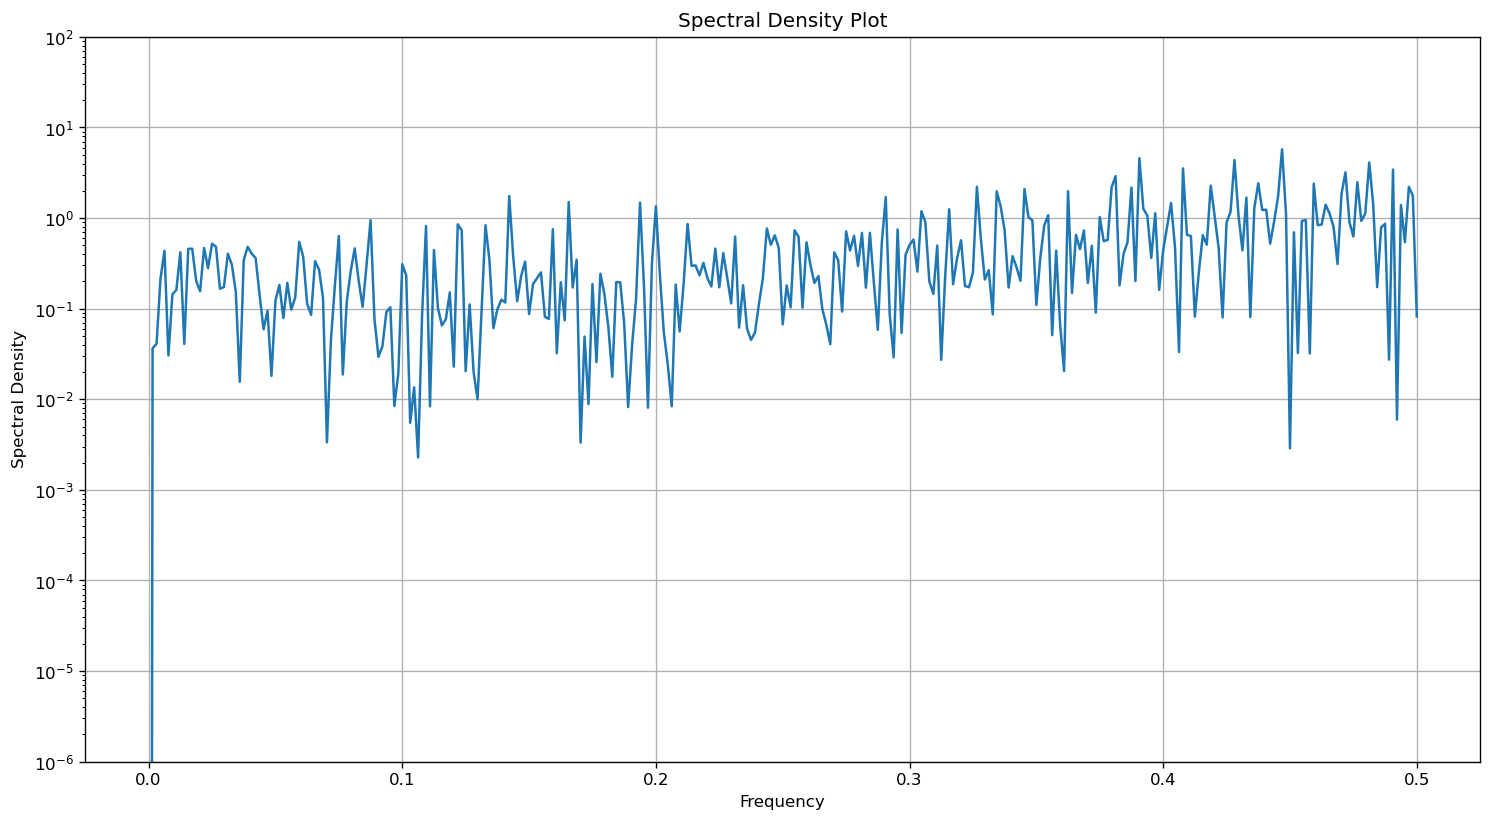

In [30]:
f, Pxx_den = signal.periodogram(train_df['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim(1e-6, 1e2)
plt.title('Spectral Density Plot')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.grid(True)
plt.show();

### Decompose the time series and confirm lack of trend in residuals

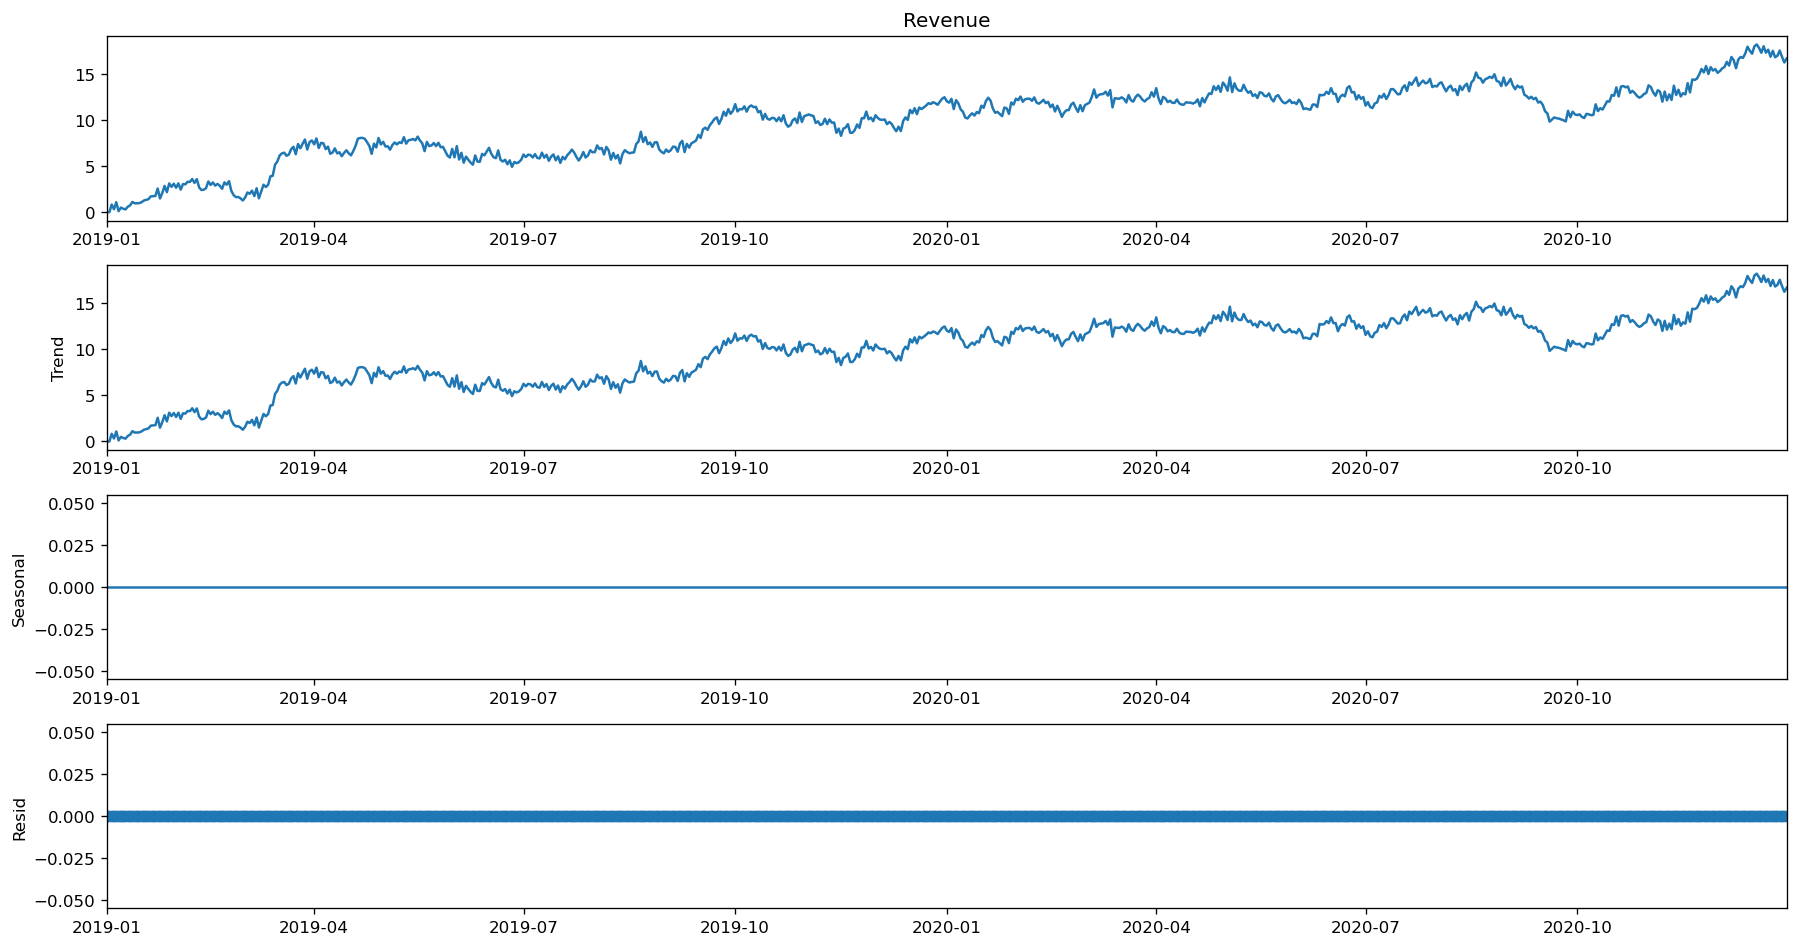

In [31]:
decomp = seasonal_decompose(df['Revenue'], period=1)
decomp.plot();

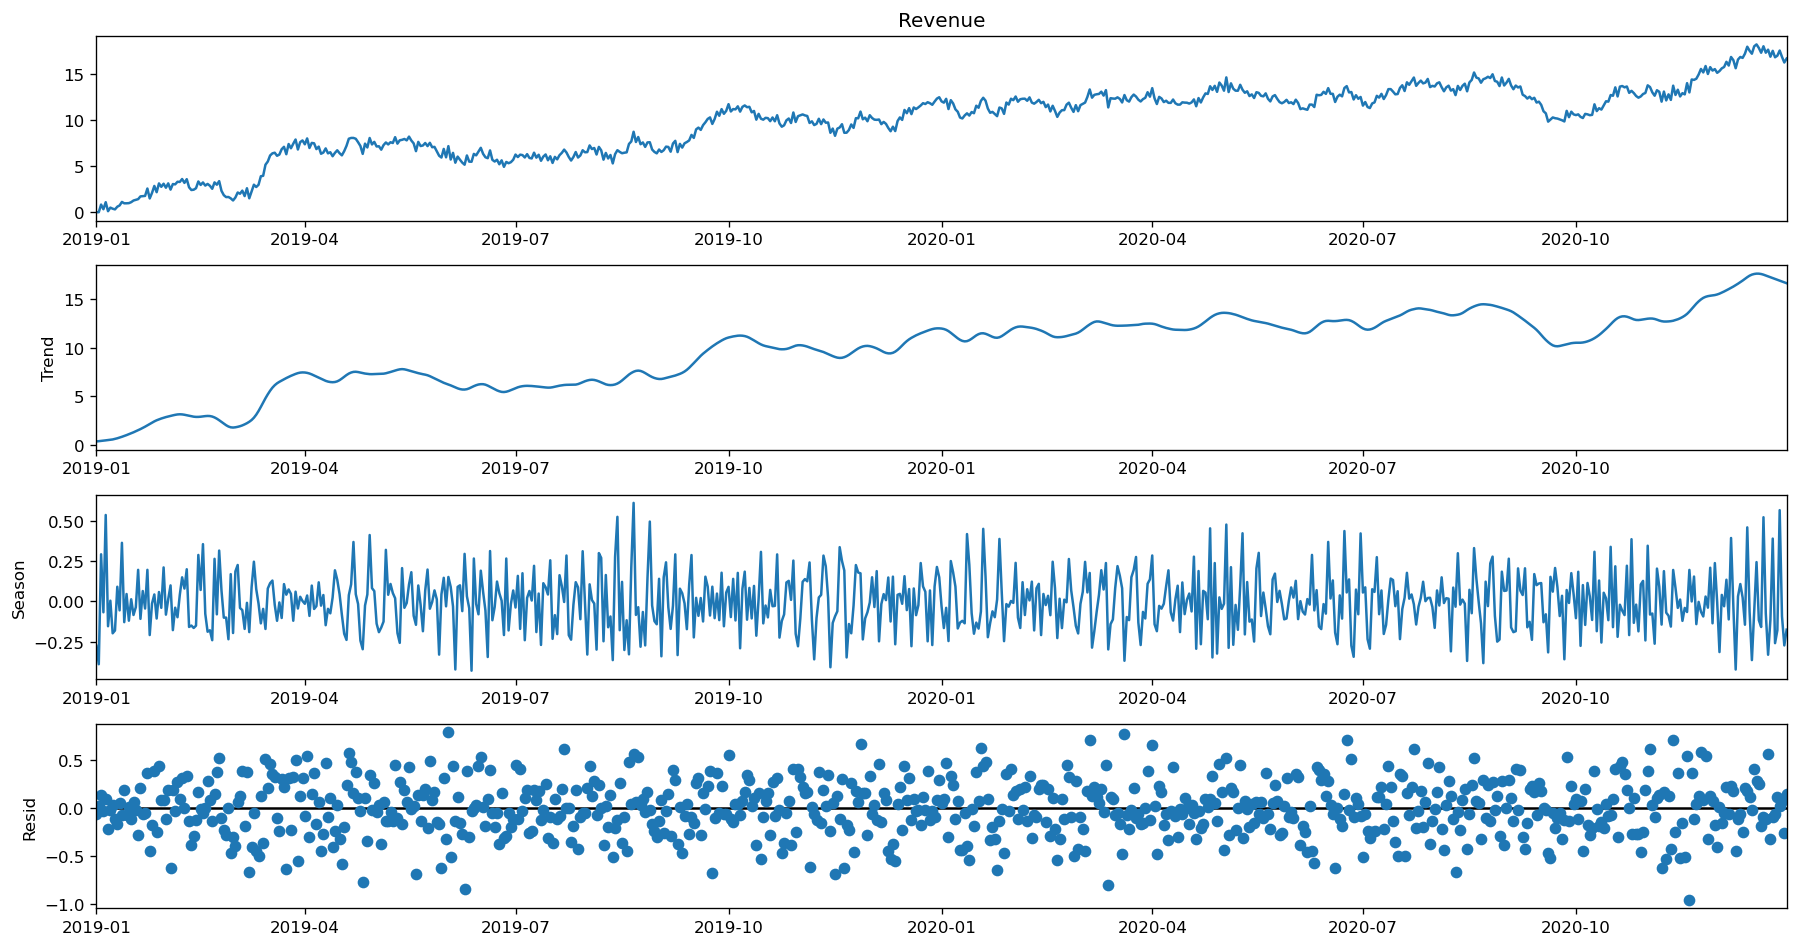

In [32]:
stl = STL(df['Revenue'])
res = stl.fit()
res.plot();

### Run auto_arima to find best fit ARIMA model

In [33]:
best_ARIMA = auto_arima(df['Revenue'], trace=True, suppress_warnings=True)
best_ARIMA.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.305, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1162.139, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=984.710, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.207 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Tue, 13 Sep 2022   AIC                            983.122
Time:                        08:40:39   BIC                            996.901
Sample:                    01-01-2019   HQIC                           988.438
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
model = SARIMAX(train_df['Revenue'], order=(1,1,0))
results = model.fit()
prediction = results.get_prediction(start=-90, dynamic=True)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  640
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -592.464
Date:                Tue, 13 Sep 2022   AIC                           1188.928
Time:                        08:40:39   BIC                           1197.848
Sample:                    01-02-2019   HQIC                          1192.391
                         - 10-02-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7294      0.028    -26.297      0.000      -0.784      -0.675
sigma2         0.3735      0.021     17.560      0.000       0.332       0.415
===================================================================================
Ljung-Box (L1) (Q):                  68.26   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.00   Prob(JB):                         0.80
Heteroskedasticity (H):               1.11   Skew:                            -0.05
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
conf_int = prediction.conf_int()
print(conf_int)

lower_limits = conf_int.loc[:,'lower Revenue']
upper_limits = conf_int.loc[:,'upper Revenue']

            lower Revenue  upper Revenue
2020-07-05      -1.619642       0.776122
2020-07-06      -1.439643       1.042276
2020-07-07      -1.931234       1.208436
2020-07-08      -1.889215       1.403791
2020-07-09      -2.175717       1.517149
...                   ...            ...
2020-09-28      -6.789698       6.204157
2020-09-29      -6.826516       6.240975
2020-09-30      -6.863128       6.277587
2020-10-01      -6.899537       6.313996
2020-10-02      -6.935746       6.350205

[90 rows x 2 columns]


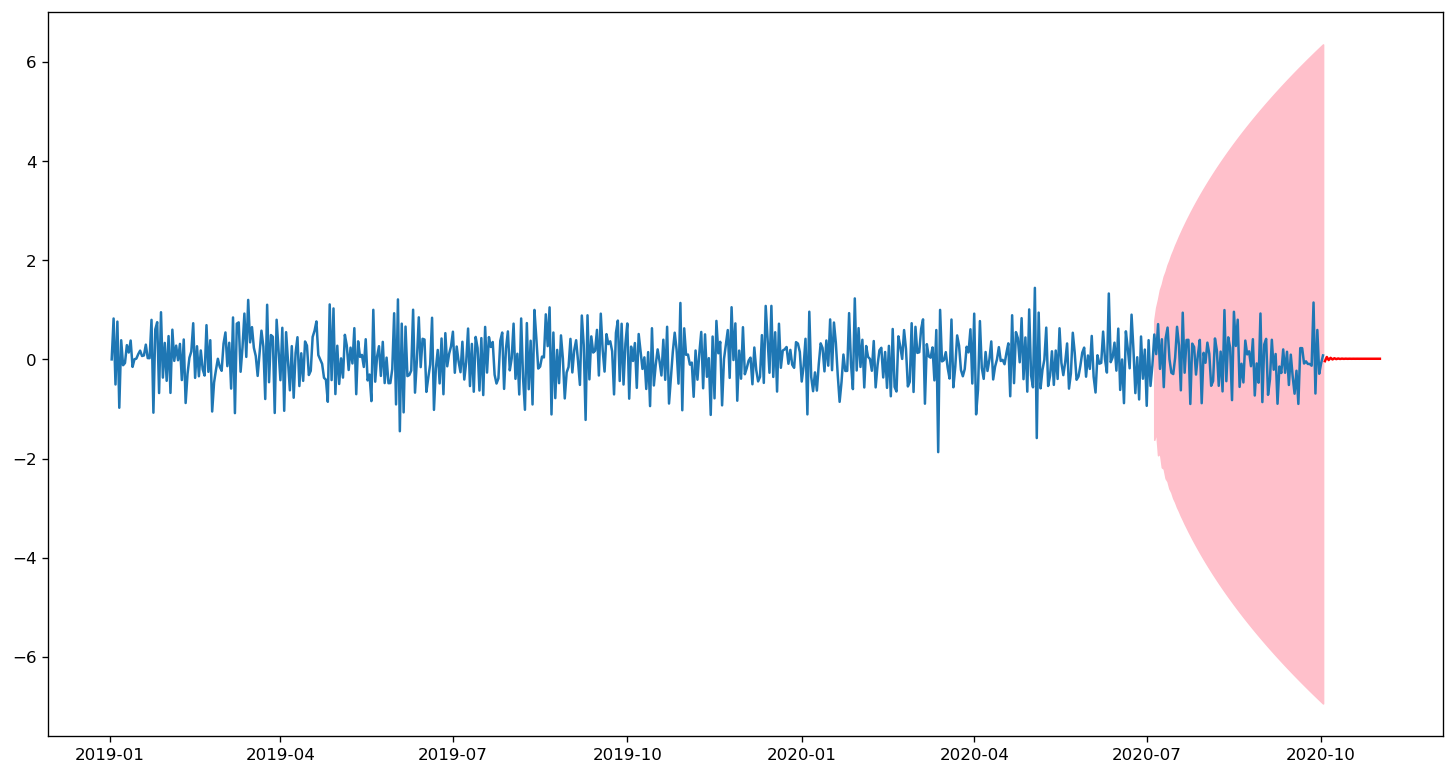

In [36]:
train_mean_forecast = results.get_forecast(steps=30).predicted_mean
plt.plot(train_df.index, train_df, label='training data')
plt.plot(train_mean_forecast.index, train_mean_forecast, color='red', label='training prediction')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink');


In [37]:
start=len(train_df)
end = len(train_df)+len(test_df)-1
pred = results.predict(start=start, end=end, typ='levels')
pred.index= df_diff.index[start:end+1]

print(pred)

Date
2020-10-03   -0.035184
2020-10-04    0.048634
2020-10-05   -0.012505
2020-10-06    0.032091
2020-10-07   -0.000438
                ...   
2020-12-27    0.013282
2020-12-28    0.013282
2020-12-29    0.013282
2020-12-30    0.013282
2020-12-31    0.013282
Name: predicted_mean, Length: 90, dtype: float64


In [38]:
test_df['Revenue'].mean()

0.06706557277777778

In [39]:
rmse = sqrt(mean_squared_error(pred,test_df['Revenue']))
print(rmse)

0.6096418353720425


In [40]:
model2 = SARIMAX(df['Revenue'], order=(1,1,0))
results2 = model2.fit()
prediction = results2.get_prediction(start=-90,dynamic=True)
mean_prediction = prediction.predicted_mean
df.tail()

,Revenue
Date,
2020-12-27,16.931559
2020-12-28,17.490666
2020-12-29,16.803638
2020-12-30,16.194814
2020-12-31,16.620798


In [41]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -490.355
Date:                Tue, 13 Sep 2022   AIC                            984.710
Time:                        08:40:39   BIC                            993.896
Sample:                    01-01-2019   HQIC                           988.254
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4667      0.033    -14.213      0.000      -0.531      -0.402
sigma2         0.2243      0.013     17.782      0.000       0.200       0.249
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.98   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
conf_int1 = prediction.conf_int()
print(conf_int1)

lower_limits = conf_int1.loc[:,'lower Revenue']
upper_limits = conf_int1.loc[:,'upper Revenue']

            lower Revenue  upper Revenue
2020-10-03       9.619459      11.475925
2020-10-04       9.513051      11.617056
2020-10-05       9.294887      11.819016
2020-10-06       9.162066      11.959399
2020-10-07       9.017948      12.099989
...                   ...            ...
2020-12-27       4.659208      16.459852
2020-12-28       4.625362      16.493698
2020-12-29       4.591708      16.527352
2020-12-30       4.558242      16.560817
2020-12-31       4.524962      16.594097

[90 rows x 2 columns]


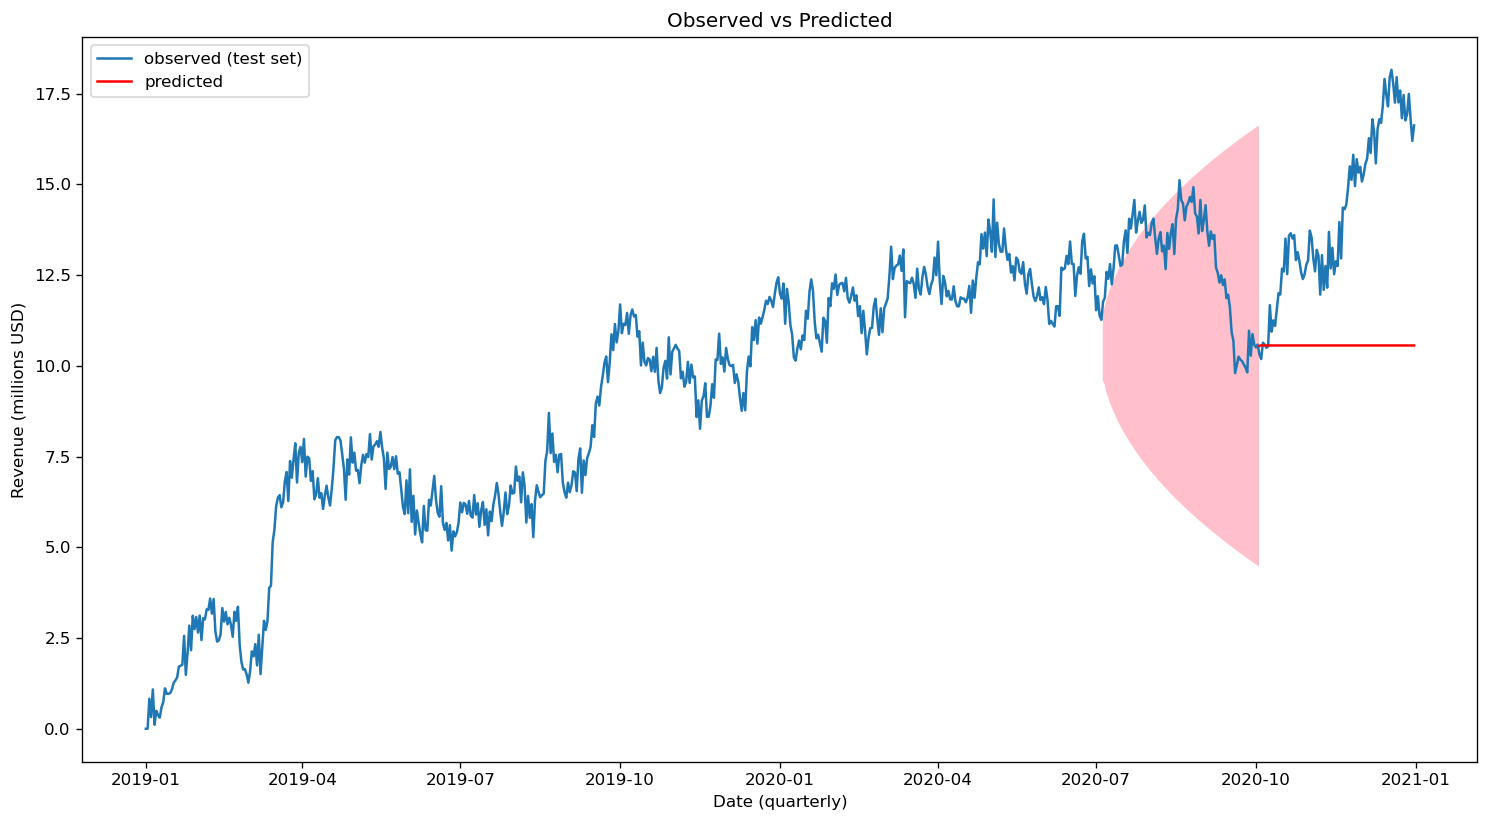

In [43]:
plt.plot(df.index, df, label='observed (test set)')
plt.plot(mean_prediction.index, mean_prediction, color='r', label='predicted')
plt.fill_between(conf_int.index, lower_limits, upper_limits, color='pink')
plt.legend()
plt.title('Observed vs Predicted')
plt.xlabel('Date (quarterly)')
plt.ylabel('Revenue (millions USD)');

In [44]:
jan_arima = SARIMAX(df['Revenue'], order=(1,1,0))
jan_arima_results = jan_arima.fit()
jan_prediction = jan_arima_results.get_prediction(start=-90,dynamic=True)
jan_arima_forecast = jan_arima_results.get_forecast(steps=30).predicted_mean
jan_arima_forecast

2021-01-01    16.422010
2021-01-02    16.514776
2021-01-03    16.471486
2021-01-04    16.491688
2021-01-05    16.482261
2021-01-06    16.486660
2021-01-07    16.484607
2021-01-08    16.485565
2021-01-09    16.485118
2021-01-10    16.485326
2021-01-11    16.485229
2021-01-12    16.485275
2021-01-13    16.485253
2021-01-14    16.485263
2021-01-15    16.485259
2021-01-16    16.485261
2021-01-17    16.485260
2021-01-18    16.485260
2021-01-19    16.485260
2021-01-20    16.485260
2021-01-21    16.485260
2021-01-22    16.485260
2021-01-23    16.485260
2021-01-24    16.485260
2021-01-25    16.485260
2021-01-26    16.485260
2021-01-27    16.485260
2021-01-28    16.485260
2021-01-29    16.485260
2021-01-30    16.485260
Freq: D, Name: predicted_mean, dtype: float64

In [45]:
conf_int2 = jan_prediction.conf_int()
print(conf_int2)

lower_limits_jan = conf_int2.loc[:,'lower Revenue']
upper_limits_jan = conf_int2.loc[:,'upper Revenue']

            lower Revenue  upper Revenue
2020-10-03       9.619459      11.475925
2020-10-04       9.513051      11.617056
2020-10-05       9.294887      11.819016
2020-10-06       9.162066      11.959399
2020-10-07       9.017948      12.099989
...                   ...            ...
2020-12-27       4.659208      16.459852
2020-12-28       4.625362      16.493698
2020-12-29       4.591708      16.527352
2020-12-30       4.558242      16.560817
2020-12-31       4.524962      16.594097

[90 rows x 2 columns]


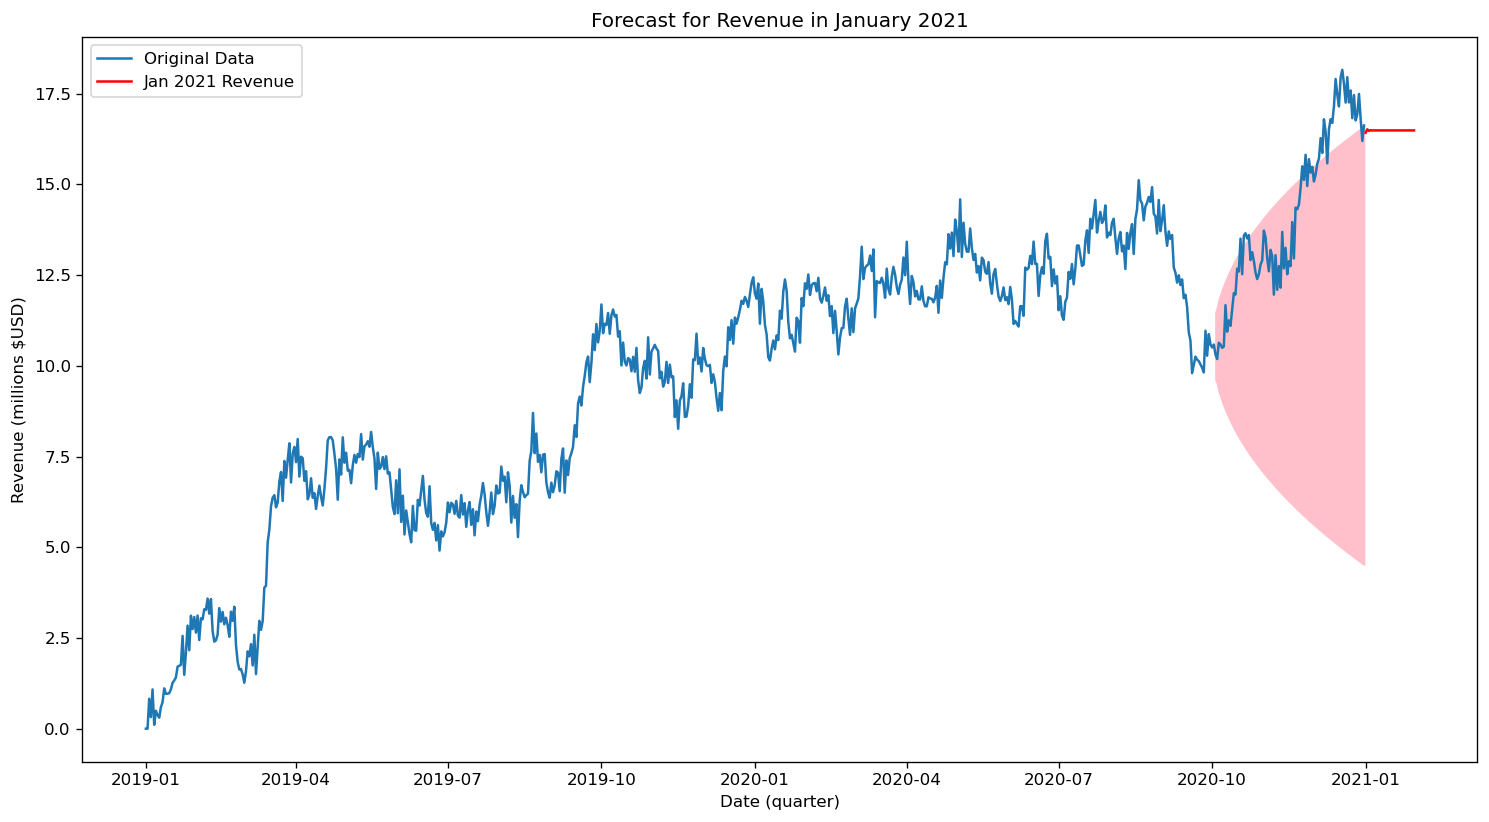

In [46]:
plt.plot(df['Revenue'].index, df['Revenue'], label='Original Data')
plt.plot(jan_arima_forecast.index, jan_arima_forecast, color='r', label='Jan 2021 Revenue')
plt.fill_between(conf_int2.index, lower_limits_jan, upper_limits_jan, color='pink')
plt.legend()
plt.title('Forecast for Revenue in January 2021')
plt.xlabel('Date (quarter)')
plt.ylabel('Revenue (millions $USD)');

In [47]:
start=len(train_df)
end = len(train_df)+len(test_df)-1
pred2 = results.predict(start=start, end=end, typ='levels')
pred2.index= df_diff.index[start:end+1]

print(pred2)

Date
2020-10-03   -0.035184
2020-10-04    0.048634
2020-10-05   -0.012505
2020-10-06    0.032091
2020-10-07   -0.000438
                ...   
2020-12-27    0.013282
2020-12-28    0.013282
2020-12-29    0.013282
2020-12-30    0.013282
2020-12-31    0.013282
Name: predicted_mean, Length: 90, dtype: float64


In [48]:
rmse = sqrt(mean_squared_error(pred2,test_df['Revenue']))
print(rmse)
rmse_model = (rmse)/(18154769-0.0)

0.6096418353720425


In [49]:
df.loc['2020-10-01']

Revenue    10.50517
Name: 2020-10-01 00:00:00, dtype: float64

In [50]:
df.loc['2020-11-01']

Revenue    13.724206
Name: 2020-11-01 00:00:00, dtype: float64

In [51]:
df.loc['2020-12-01']

Revenue    15.07793
Name: 2020-12-01 00:00:00, dtype: float64

In [52]:
df.loc['2020-12-31']

Revenue    16.620798
Name: 2020-12-31 00:00:00, dtype: float64

In [53]:
jan_arima_forecast.loc['2021-01-01']

16.422010329494288

In [54]:
jan_arima_forecast.loc['2021-01-08']

16.48556487549214

In [55]:
jan_arima_forecast.loc['2021-01-15']

16.485258594369007

In [56]:
jan_arima_forecast.loc['2021-01-22']

16.48526007039444

In [57]:
jan_arima_forecast.loc['2021-01-30']

16.48526006333124

In [58]:
jan_arima_forecast.loc['2021-01-30'] - df.loc['2020-12-31']

Revenue   -0.135538
Name: 2020-12-31 00:00:00, dtype: float64

In [59]:
jan_rev_change = (16.620798) / (0.135528)
print('The forecasted loss in revenue for January 2021 could be',
      jan_rev_change,'thousand dollars')

The forecasted loss in revenue for January 2021 could be 122.63737382681069 thousand dollars
